In [1]:
# 1. Ar + Master list
# 2. expm = e^(itAlambda) = S
# 3. S^2 = Ig -> GP -> Ug
# use weak beam approximation after it works

# program: qeda: 'Quantitative Electron Diffraction Analysis' 

    # First we read/create in the experimental conditions.
    # We need: 
    # - the microscope parameters (high tension)
    # - the (indexed) reciprocal lattice
    # - the zone axis
    # - the array of kt-vectors (this could also be defined as equally spaced, with some maximum value)
    # 
    # There are 2 options for this code: 
    # a) compute a LARBED pattern (requires knowledge of crystal structure)
    # b) analyze an experimental data set (requires measured intensities and spot positions)
    # We should first complete a), because we can then use that as input to b)
    ############################################/
#%%
import os
import pyQEDA as pq #note this python source file/jupyter notebook should not be called 'pyQEDA.py' as this is reserved for the pyQEDA module as will cause a conflict if named so
import numpy as np
import requests
import math
import matplotlib.pyplot as plt
currentPath = os.getcwd()
import sys


sys.path.append("/Users/chenjie/pyQEDA/pyscripts")
import pyQEDA_function
import pyQEDA_potential as pqp
import normalization_function as nf
import makeUniqueUgVector_cj as mu
import makeUniqueUgVector_3D_cj as mu_3D

In [2]:
filename = "SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.qed"
#filename = "ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.qed"
#filename = "ZnO_001_Th500A_T30mrad_r4_maxg_1_100kV.qed" #enter the QEDA parameter file here (including filetype)
filename = currentPath + "/Jie_parameter_files/" + filename
cfgFolder="/crystal_files/" #these input and output folders are appended to the beginnng of the string read from the .qed file
outputFolder="/pyQEDA_simulations/"
#imageFolder="/pyQEDA_simulations/" #these input and output folders are appended to the beginnng of the string read from the .qed file
#if using experimental intensities
expImageFolder = "/experimental_data/"
expImageFolder = currentPath + expImageFolder
#traing Data(Pattern Folder & Ug Folder)
trainingFolder = "/training_Data/"
trainingFolder = currentPath + "/training_Data/"

In [3]:
#%% Default parameters if no input file is available

# Let's start with a few settings:
computeTermMaps = 0
############################################/
# Here are a few default parameters which should be overwritten by an input data file:


n = ([0.0,0.0,1.0]) #surface normal (surface slab normal points against the beam)
zone = ([0.0,0.0,1.0]) #which zone axis (crystal orientation)
gx = ([1.0,0.0,0.0])    #the g vector
ktOffset = ([0.0,0.0])
highTension = 120    #the electron bean energy in kV
gCutoff = 2.5      # cut off reflections at 3 1/A
sgCutoff    = 0.025; # select reflections that are closer than 0.2 1/A to the Ewald sphere.
thickness   = 130.0; # thickness in A.
scanComp    = 0.0; #scan compensation can be used to descan the beam to ensure there are no overlapping beams, (with full scan compensation there is no rocking curve, only integrated spots)
detectorNx  = 700 #size of the detector
detectorNy  = detectorNx
tiltRange_mrad = 40 
discRadius_pixel = 3  #the scan pattern is a disc, this parameter chooses how many scan points to fit in one radius and the total scan points is then calculated to fit inside the disc.
q , approxOrder = 0, 0
termThresh = 0.0001 
targetUg = 0.01


Generate_random_diffs = True
UseInputUgMasterList = False

if UseInputUgMasterList:
    Generate_random_diffs = False #dont use both at the same time

elif Generate_random_diffs: 
    N_training_data = 200 #How many times to run the simulation. Right now, it outputs random Ug vectors on every run. These can be used to train a Neural network.
    RandomUgMasterList = []
    random_diffs = []
else:
    diff_pattern = []
    N_training_data = 1

In [4]:
#This function has 2 versions run from a folder or from InputUg and InputBeams 
# It displays the potential from the simulation with an option to charge flip below a threshold 
# When run from a folder, beams are also output which is necessary for running in the other mode. 
# The order should be 
# 1. run pyQEDA simulation normally with no random Ug (and do not run this cell yet)
# 2. run this this function like this to get beams as a variable (alternatively you could write another function that just reads the BeamList.txt file)
# 3. run the notebook with generate_random_diffs = True. This will generate random Ug, charge flip them, then use the flipped Ug as input. This creates more realistic intensities.
#[UgList0, potMapExp, beams] = pqp.displayPotentialFromUg('',\
#                                                          potSize=([256,256]), \
#                                                          Ncells=([2,2]),     \
#                                                          showImag=True,      \
#                                                          doFlip=True,       \
#                                                          thresh = 0.15,     \
#                                                          beta = 0.9,\
#                                                         InputUg=None,\
#                                                         InputBeams=None,\
#                                                         returnComplexUg=False,\
#                                                         scaling=1)

In [5]:
def read_parameter_file(filename,training_data):    
    with open(filename, "r") as f:
        for line in f:
            if 'mode:' in line:
                mode = line[line.index(':')+1:-1].strip(' ')
                print(f"mode = \t\t{mode}") 
            if 'cfg file:' in line:
                cfgName = currentPath + cfgFolder + line[line.index(':')+1:-1].strip(' ')
                print(f"cfg file = \t\t{cfgName}") 
            if 'output folder:' in line:
                outputName = line[line.index(':')+1:-1].strip(' ')
                if Generate_random_diffs:
                    outputPath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "_training_data_" + str(training_data)
                elif UseInputUgMasterList:
                    outputPath = currentPath + outputFolder + "/" + outputName + "/" + outputName
                else:
                    outputPath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "_experimental_data"
                print(f"created output folder = \t\t{outputFolder}")
                if os.path.exists(outputPath):
                    print("file exists")
                else:
                    pass
                    os.makedirs( outputPath )
            if 'output file:' in line:
                imageName = line[line.index(':')+1:-1].strip(' ') 
                if Generate_random_diffs:
                    imagePath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "_training_data_" + str(training_data) + "/" + imageName                          
                elif UseInputUgMasterList:
                    imagePath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "/" + imageName
                else:
                    imagePath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "_experimental_data" + "/" + imageName
                print(f"output file = \t\t{imagePath}")    
            if 'zone axis:' in line:
                zone = line[line.index(':')+1:-1].strip(' ')
                zone = list(zone.split(" "))
                zone = [float(i) for i in zone]
                print(f"zone axis= \t\t{zone}") 
            if 'gx vector:' in line:
                gx = line[line.index(':')+1:-1].strip(' ')
                gx = list(gx.split(" "))
                gx = [float(i) for i in gx]
                print(f"gx vector= \t\t{gx}")
            if 'surface normal:' in line:
                n = line[line.index(':')+1:-1].strip(' ')
                n = list(n.split(" "))
                n = [float(i) for i in n]
                print(f"surface normal = \t\t{n}")           
            if 'tilt offset (mrad):' in line:
                ktOffset = line[line.index(':')+1:-1].strip(' ')
                ktOffset = list(ktOffset.split(" "))
                ktOffset = [float(i) for i in ktOffset]
                print(f"tilt offset (mrad) = \t\t{ktOffset}") 
            #% Parameters for scattering path approximation
            if 'approximation:' in line:    # 0=Bloch wave, 1=kinematic, >1=Scatt. patch expansion
                approxOrder = line[line.index(':')+1:-1].strip(' ')
                approxOrder = int(approxOrder.split("%")[0].strip('\t').strip(' '))
                print(f"approximation = \t\t{approxOrder}")
            if 'term threshold:' in line:   # fraction of total intensity above which to include a term
                termThresh = line[line.index(':')+1:-1].strip(' ')
                termThresh = float(termThresh.split("%")[0].strip('\t').strip(' '))
                print(f"term threshold = \t\t{termThresh}") 
            if 'target Ug:' in line:   #  maximum value expected for any Ug (only used for term selection)
                targetUg = line[line.index(':')+1:-1].strip(' ')
                targetUg = float(targetUg.split("%")[0].strip('\t').strip(' '))
                print(f"target Ug = \t\t{targetUg}")
            if 'high tension:' in line:   #  maximum value expected for any Ug (only used for term selection)
                highTension = line[line.index(':')+1:-1].strip(' ')
                highTension = float(highTension.split("%")[0].strip('\t').strip(' '))
                print(f"high tension = \t\t{highTension}")
            if 'max g vector:' in line:   # gCutoff in 1/A.
                gCutoff = line[line.index(':')+1:-1].strip(' ')
                gCutoff = float(gCutoff.split("%")[0].strip('\t').strip(' '))
                print(f"max g vector = \t\t{gCutoff}")
            if 'max sg:' in line:   # sgCutoff, selects reflections that are closer than 0.02 1/A to the Ewald sphere.
                sgCutoff = line[line.index(':')+1:-1].strip(' ')
                sgCutoff = float(sgCutoff.split("%")[0].strip('\t').strip(' '))
                print(f"max sg = \t\t{sgCutoff}") 
            if 'thickness:' in line:   # thickness in A
                thickness = line[line.index(':')+1:-1].strip(' ')
                thickness =  float(thickness.split("%")[0].strip('\t').strip(' '))
                print(f"thickness = \t\t{thickness}")
            if 'scan compensation:' in line:   #scan Compensation as in the QED acquisition
                scanComp = line[line.index(':')+1:-1].strip(' ')
                scanComp =  float(scanComp.split("%")[0].strip('\t').strip(' '))
                print(f"scan compensation = \t\t{scanComp}")
            if 'tilt range (mrad):' in line:   
                tiltRange_mrad = line[line.index(':')+1:-1].strip(' ')
                tiltRange_mrad =  float(tiltRange_mrad.split("%")[0].strip('\t').strip(' '))
                print(f"tilt range (mrads) = \t\t{tiltRange_mrad}")
            if 'disc radius (pixels):' in line:   #disc diameter will be di = 2ri+1
                discRadius_pixel = line[line.index(':')+1:-1].strip(' ')
                discRadius_pixel =  int(discRadius_pixel.split("%")[0].strip('\t').strip(' '))
                print(f"disc radius (pixels) = \t\t{discRadius_pixel}")
            if 'detector size x:' in line: 
                detectorNx = line[line.index(':')+1:-1].strip(' ')
                detectorNx =  int(detectorNx.split("%")[0].strip('\t').strip(' '))
                detectorNy = detectorNx
                print(f"detector size x = \t\t{detectorNx}")
                
    return mode,cfgName,outputName,outputPath,imageName,imagePath,zone,gx,n,ktOffset,approxOrder,termThresh,highTension,gCutoff,sgCutoff,thickness,scanComp,tiltRange_mrad,discRadius_pixel,detectorNx,detectorNy




In [6]:
if Generate_random_diffs: 
    RandomUgMasterList = []
    random_thickness = []
    UgLists = []
    random_diffs = []
    Ug_normalized_matrix = []
    DoFlip = False
    MakeUniqueUg = True
else:
    diff_pattern = []
    N_training_data = 1

mode = 'LARBED_SIM' #LARBED_SIM by default

for training_data in range(N_training_data):
    print(f'\niteration={training_data}')

    if mode == 'LARBED_SIM':
        
        #read the parameter file which assigns the relevant variables
        mode,cfgName,outputName,outputPath,imageName,imagePath,zone,gx,n,ktOffset,approxOrder,termThresh, \
        highTension,gCutoff,sgCutoff,thickness,scanComp,tiltRange_mrad,discRadius_pixel,detectorNx,detectorNy \
        = read_parameter_file(filename,training_data)
        
        # read the crystal structure from a .cfg file:
        Xtal = pq.Crystal(cfgName)

        print(f"\n* QEDA: Simulation of {cfgName}, zone = {zone}\n")
        ############################################/
        # Now we can allocate and initialize the pattern collection (e.g. LARBED data set).
        # This also assigns it the crystal object containing lattice parameters, etc.
        # dataSet = pq.PatternCollection(Xtal,highTension,zone,n,gx,gCutoff,sgCutoff)
        dataSet = pq.PatternCollection(Xtal,highTension,zone,n,gx,gCutoff,sgCutoff)
        
        #   # If we want to do simulations we can automatically create a disc pattern with a certain radius
        #   # and a given number of pixels spanning the radius:
        dataSet.GenerateDisc( tiltRange_mrad , discRadius_pixel , ktOffset)

        # For curiosity, we can look how many beams have been selected for each pattern
        dataSet.PrintTilts()
        #dataSet.CreateBeamCountMap()
        nBeamsTotal = dataSet.CreateUgMasterList()
        
        if Generate_random_diffs:
            thickness = np.random.randint(50,500)
            print(f'thickness={thickness}')
            random_thickness.append(thickness)
            
            #generate a list of random Ug
            #RandomUgMasterList.append( dataSet.ComputeRandomUgMasterList() ) #this random set of Ug is generated (useful for ML training)
            
            
            RandomUgMasterList.append( dataSet.GetRandomUgMasterList(0.2,0.4) )#Sherjeel implementation of random vectors(similar but with Ug limits
            print(f'\n\nRandom Ug List {training_data} = \n\n{RandomUgMasterList[training_data]}\n')
            
            if DoFlip == True:
                #select this iteration Ug and change from complex to alternative real,imag,real,imag....
                InputUg = np.asarray(RandomUgMasterList[training_data])
                InputUg = np.ravel([InputUg.real,InputUg.imag],'F')
            
                #This function takes in a set of Ug and beams (beams need to be defined this is why the function is run  near the beginning)                   
                #It converts Ug -> potential map and *(-1) values below the defined threshold then -> Ug and is output as a complex list. Also available is the potential map output
                [UgList, potMapSim] = pqp.displayPotentialFromUg(folder='SrTiO3_001_Th500A_T80mrad_r9_maxg_1_5_60kV.qed.qed',\
                                       potSize=([256,256]), \
                                       Ncells=([2,2]),     \
                                       showImag=True,      \
                                       doFlip=True,       \
                                       thresh = 0.01,     \
                                       beta = 0.9,\
                                       InputUg=InputUg,\
                                       InputBeams = beams, \
                                       returnComplexUg=True,\
                                       scaling=1)
                        
                #This 'charge flipped' Ug list is then used in the diffraction simulation
                UgLists.append(UgList)
                origin_Ug = UgLists[training_data]
                #dataSet.UseInputUgMasterList(UgList)
            else:
                origin_Ug = RandomUgMasterList[training_data]
                            

            #filepath = "/Users/chenjie/pyQEDA/pyQEDA_simulations/" + outputName + "/" + outputName + "_experimental_data" +'/'
            #beamfilename = '_BeamList.txt'
            #beamfile = filepath + beamfilename
            #beams = np.asarray(np.loadtxt(beamfile,skiprows=1, usecols= range(1, 4)  ), dtype=int )
            
            Ug_normalized = nf.normalization(file = "SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV", origin_Ug=origin_Ug)
            
            if MakeUniqueUg == True:
                
                UgUnique, r0 = mu.makeUniqueUgVector(Ug_normalized,1,8,file = "SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV")
                #print("Applied shift of unit cell origin (fractional coordinates):",r0[0],r0[1])
                #for j in range(beams.shape[0]):
                #    print("Ug[",j,"]:",np.round(np.abs(Ug_normalized[j]),5),np.round(np.angle(Ug_normalized[j]),5),
                #          " => ",np.round(np.abs(UgUnique[j]),5),np.round(np.angle(UgUnique[j]),5))
                
                Ug_normalized = UgUnique
                                                                        
            Ug_normalized_matrix.append(Ug_normalized)
            dataSet.UseInputUgMasterList(Ug_normalized)
            
            print(f'Ug_normalized:\n{Ug_normalized}\n')
            dataSet.PrintUgMasterListVoid()
            

        elif UseInputUgMasterList:
            InputUgRaw = np.loadtxt("/Users/chenjie/pyQEDA/training_Data/predicted_ug_t_test.csv")
            InputUg = np.array(range( np.int((InputUgRaw.size - 1)/2) ), dtype=complex)
            thickness = InputUgRaw[-1] * 1000
            InputUg.real = InputUgRaw[0:-1:2] 
            InputUg.imag = InputUgRaw[1:-1:2]
            print(f"thickness={thickness}")    
            print(f"InputUg = {InputUg.shape}")

            #Can do charge flipping here also if you like this will charge flip input Ug values (e.g Neural Network)
#             [UgList, potMapSim] = pqp.displayPotentialFromUg(folder=None,\
#                                                       potSize=([256,256]), \
#                                                       Ncells=([2,2]),     \
#                                                       showImag=True,      \
#                                                       doFlip=True,       \
#                                                       thresh = 0.01,     \
#                                                       beta = 0.9,\
#                                                       InputUg=np.ravel([InputUg.real,InputUg.imag],'F'),\
#                                                       InputBeams = beams, \
#                                                       returnComplexUg=True,\
#                                                       scaling=1)

            dataSet.UseInputUgMasterList(InputUg)
            print(f'InputUg:\n{InputUg}\n')
            dataSet.PrintUgMasterListVoid()
            
        else:
            # Next, we can generate the structure factor master list
            nBeamsTotal = dataSet.CreateUgMasterList()
            print(f"\n\nAll patterns together contain {nBeamsTotal} different beams\n")
            dataSet.ComputeUgMasterList()      #for a normal simulation this would be used instead of generating a random set of Ug
            dataSet.PrintUgMasterListVoid()
    

        # if we use the scattering path expansion, then convergence will be slowed down by the large value of U0.
        # We therefore simply set U0 to zero:
#         if approxOrder !=  0:
#             dataSet.resetU0()
#             if computeTermMaps == 1:
#                 for q in range(1,abs(approxOrder)):
#                     dataSet.ComputeDiffraction(thickness,-q,termThresh,targetUg)
#                     print(f"{mapName},termMap_q={q}.img")
#                     if Generate_random_diffs:
#                         random_diffs.append(dataSet.CreateDiffPat(mapName,detectorNx,detectorNy,scanComp) ) 
#                     else:
#                         diff_pattern.append( dataSet.CreateDiffPat(mapName,detectorNx,detectorNy,scanComp) )          

        # # for debugging purposes only:
        #dataSet.PrintUgMasterListVoid()
        
        if (approxOrder >= 0):
            # And now, we can start the dynamical calculation.
            dataSet.ComputeDiffraction(thickness,approxOrder,termThresh,targetUg)

            # # Let's save the data in binary format, so that we can analyze it later:
            dataSet.SaveDiffractionIntensities( imagePath )


            # # Finally, we ant to display the pattern.
            if Generate_random_diffs:
                random_diffs.append( dataSet.CreateDiffPat( detectorNx,detectorNy,scanComp) ) #this returns a variable of the diffraction pattern
            else:        
                diff_pattern.append( dataSet.CreateDiffPat( detectorNx,detectorNy,scanComp) ) #there is also a function to save to file


        # write all the simulated intensities, matrix diagonals, and Ar's to disk 
        dataSet.WriteSimulationParameters(outputPath)
        dataSet.PrintUgMasterList(outputPath  + "/_BeamList.txt" , 1)
        dataSet.PrintUgMasterList(outputPath  + "/_UgMasterList.txt" , 0)

        ###############################################/
        # let's also fit kinematic rocking curves to get a first estimate of the structure factors:
        # First, we need to load the experimental data:
        dataSet.LoadDiffractionIntensities( imagePath  )
        nBeamsTotal = dataSet.CreateUgMasterList()
        print(f"\nAll patterns together contain {nBeamsTotal} different beams\n")
        # Now, we can fit the diffraction data, first with kinematic theory, 
        # then with higher order approximations to dynamical theory: 
        # This function will populate the real parts of those Ugs in the masterUg 
        # array which are represented by actual diffraction intensities.
        errVal = dataSet.FitKinematicRockingCurves(thickness)
        print(f"Residual error after kinematic rocking curve fit: {errVal}\n")
        dataSet.PrintUgMasterList( (outputPath + "/_UgMasterList_KinematicFit.txt") , 0 )   
        

        
        
        
#     if mode == 'LARBED_REC':
#         print("* QEDA: Reconstruction from file %s\n",imagePath)

#         ############################################/
#         #First, we need to load the experimental data:
#         dataSet.LoadDiffractionIntensities(Image)
#         # The crystal unit cell parameters have already been loaded (the actual atom positions will not be used)
#         #Next, we can generate the structure factor master list (we won't compute them yet):
#         dataSet.PrintTilts();

#         nBeamsTotal = dataSet.CreateUgMasterList()
#         print(f"All patterns together contain {nBeamsTotal} different beams\n")

#         ############################################/
#         #Now, we can fit the diffraction data, first with kinematic theory, 
#         #then with higher order approximations to dynamical theory: 
#         # This function will populate the real parts of those Ugs in the masterUg 
#         #array which are represented by actual diffraction intensities.
#         errVal = dataSet.FitKinematicRockingCurves(thickness)
#         print("Residual error after kinematic rocking curve fit: %f\n",errVal)

#         #Just for debugging purposes, to see if starting with the correct solution we will also stay there:
#         #dataSet.ComputeUgMasterList()
#         dataSet.resetU0()
#         dataSet.PrintUgMasterListVoid()

#         if (approxOrder > 1):
#             case = 0
#             if case == 0:
#                 for i in range(50): 
#                     print("\n\n***** Iteration %d *****\n",i)
#                     errVal = dataSet.RefineStructureFactorsDynamicOnly(2,100,thickness)
#                     print("Residual error after double scattering rocking curve fit to dynamical part only: %f\n",errVal)
#                     errVal = dataSet.RefineStructureFactors(2,5,thickness)
#                     print("Residual error after double scattering rocking curve fit: %f\n",errVal)
#                     errVal = dataSet.RefineStructureFactorsLocal(2,15,thickness)
#                     print("Residual error after multivariate double scattering rocking curve fit: %f\n",errVal)

#                     errVal = dataSet.RefineStructureFactors(2,5,thickness)
#                     print("Residual error after double scattering rocking curve fit: %f\n",errVal)

#             if case == 1:
#                 errVal = dataSet.RefineStructureFactors(2,100,thickness)
#                 print("Residual error after double scattering rocking curve fit: %f\n",errVal)
#                 errVal = dataSet.RefineStructureFactorsLocal(2,100,thickness)
#                 print("Residual error after multivariate double scattering rocking curve fit: %f\n",errVal)

#             if case == 2:
#                 # dataSet.PrintUgMasterList();
#                 errVal = dataSet.RefineStructureFactors(2,100,thickness)
#                 print("Residual error after double scattering rocking curve fit: %f\n",errVal)

#                 dataSet.PrintUgMasterList()
#                 dataSet.SetDk(tiltRange_mrad,discRadius_pixel)
#                 dataSet.CreateDiffPat("temp2.img",detectorNx,detectorNy,scanComp)


#             #Xtal.Print();



iteration=0
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_0/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=358


Random Ug List 0 = 

[(0.0717185623346449+0.17387715837633105j), (-0.04539271016805342+0.0075654718196286365j), (0.12895864327915707-0.181351


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036713237518208035


iteration=1
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_1/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=336


Random Ug List 1 =


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.033605975434207895


iteration=2
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_2/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=116


Random Ug List 2 =


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03195820673371577


iteration=3
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_3/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=104


Random Ug List 3 = 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.0326415605190946


iteration=4
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_4/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=192


Random Ug List 4 = 



All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03390910119728445


iteration=5
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_5/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=464


Random Ug List 5 = 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.040970355531499386


iteration=6
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_6/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=233


Random Ug List 6 =


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.0358208829930915


iteration=7
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_7/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=295


Random Ug List 7 = 



All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037348895202881816


iteration=8
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_8/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=166


Random Ug List 8 =


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03308985313000593


iteration=9
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_9/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=259


Random Ug List 9 = 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03962965454845136


iteration=10
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_10/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=243


Random Ug List 10


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03361281294349474


iteration=11
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_11/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=438


Random Ug List 11


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03907101803515979


iteration=12
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_12/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=463


Random Ug List 12


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03914124787465546


iteration=13
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_13/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=367


Random Ug List 13


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03743229352257482


iteration=14
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_14/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=145


Random Ug List 14


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.0326577212429949


iteration=15
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_15/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=201


Random Ug List 15 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03413736856037787


iteration=16
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_16/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=258


Random Ug List 16


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03543751841556661


iteration=17
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_17/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=336


Random Ug List 17


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03859873770230363


iteration=18
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_18/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=377


Random Ug List 18


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03741324662480172


iteration=19
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_19/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=436


Random Ug List 19


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03757536455906825


iteration=20
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_20/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=62


Random Ug List 20 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.022323559413339526


iteration=21
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_21/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=449


Random Ug List 2


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03655428097294303


iteration=22
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_22/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=288


Random Ug List 22


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036512588865978114


iteration=23
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_23/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=393


Random Ug List 2


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03907186546228574


iteration=24
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_24/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=51


Random Ug List 24 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.017429058837671946


iteration=25
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_25/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=367


Random Ug List 2


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03977753426413125


iteration=26
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_26/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=407


Random Ug List 26


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03945313568180912


iteration=27
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_27/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=73


Random Ug List 27 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.023336322531395847


iteration=28
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_28/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=244


Random Ug List 2


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03418862079377491


iteration=29
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_29/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=277


Random Ug List 29


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.034218001537890064


iteration=30
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_30/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=212


Random Ug List 3


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03331178812798738


iteration=31
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_31/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=270


Random Ug List 31


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03739852275324291


iteration=32
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_32/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=362


Random Ug List 32


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.038739704207911244


iteration=33
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_33/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=103


Random Ug List 3


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03116254105120916


iteration=34
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_34/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=228


Random Ug List 34


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037368183398945494


iteration=35
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_35/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=119


Random Ug List 3


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.02852108150463926


iteration=36
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_36/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=351


Random Ug List 36


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03730658598728278


iteration=37
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_37/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=283


Random Ug List 37


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.040615101387277544


iteration=38
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_38/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=227


Random Ug List 3


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.04118167704129043


iteration=39
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_39/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=94


Random Ug List 39 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.02873317251821792


iteration=40
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_40/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=309


Random Ug List 40


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03683220835079865


iteration=41
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_41/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=322


Random Ug List 41


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.038488941570348156


iteration=42
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_42/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=471


Random Ug List 4


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03863019476378081


iteration=43
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_43/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=121


Random Ug List 43


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.02906188955718341


iteration=44
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_44/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=397


Random Ug List 44


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037868752570202724


iteration=45
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_45/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=87


Random Ug List 45


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.02910203706474548


iteration=46
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_46/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=454


Random Ug List 46


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037073505704248146


iteration=47
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_47/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=482


Random Ug List 4


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03805305710765433


iteration=48
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_48/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=257


Random Ug List 48


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03795887083328928


iteration=49
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_49/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=416


Random Ug List 49


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03802277546687289


iteration=50
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_50/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=299


Random Ug List 50


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036781210071078756


iteration=51
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_51/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=379


Random Ug List 5


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.04185287162862021


iteration=52
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_52/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=307


Random Ug List 52


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037148046751726733


iteration=53
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_53/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=357


Random Ug List 5


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.038200404326464765


iteration=54
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_54/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=82


Random Ug List 54


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03284243907842321


iteration=55
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_55/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=119


Random Ug List 55


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.02921408031308907


iteration=56
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_56/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=78


Random Ug List 56 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.0253344337158529


iteration=57
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_57/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=225


Random Ug List 57 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036124841189903355


iteration=58
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_58/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=201


Random Ug List 5


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03528758162824056


iteration=59
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_59/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=158


Random Ug List 59


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03538066163061792


iteration=60
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_60/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=498


Random Ug List 60


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03857015494880936


iteration=61
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_61/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=369


Random Ug List 61


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03776270395031697


iteration=62
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_62/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=280


Random Ug List 62


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03429732854321812


iteration=63
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_63/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=232


Random Ug List 63


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036301709539420045


iteration=64
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_64/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=445


Random Ug List 6


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03631588273338792


iteration=65
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_65/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=64


Random Ug List 65 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.025817829148132784


iteration=66
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_66/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=54


Random Ug List 66


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.007914258968442845


iteration=67
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_67/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=352


Random Ug List 6


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037546447584988395


iteration=68
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_68/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=466


Random Ug List 6


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.038420372987363595


iteration=69
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_69/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=246


Random Ug List 6


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03445235904470162


iteration=70
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_70/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=159


Random Ug List 70


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.035335348608805224


iteration=71
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_71/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=468


Random Ug List 7


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03606882284728604


iteration=72
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_72/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=79


Random Ug List 72 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.025472835755178336


iteration=73
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_73/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=137


Random Ug List 7


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.030039438623794712


iteration=74
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_74/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=217


Random Ug List 7


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03711820622733347


iteration=75
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_75/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=435


Random Ug List 75


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03506333017668214


iteration=76
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_76/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=97


Random Ug List 76 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.028168450030327405


iteration=77
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_77/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=423


Random Ug List 7


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.035933573352285746


iteration=78
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_78/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=67


Random Ug List 78


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.022598326733472597


iteration=79
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_79/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=459


Random Ug List 7


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03590363291950446


iteration=80
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_80/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=136


Random Ug List 80


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03338465274616061


iteration=81
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_81/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=105


Random Ug List 81


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.024649997360874743


iteration=82
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_82/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=366


Random Ug List 8


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037285301677380485


iteration=83
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_83/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=350


Random Ug List 8


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037482301924401974


iteration=84
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_84/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=215


Random Ug List 8


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03527702947179607


iteration=85
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_85/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=199


Random Ug List 85


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03685588585554372


iteration=86
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_86/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=347


Random Ug List 86


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03309435074905998


iteration=87
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_87/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=310


Random Ug List 87


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037265762877775256


iteration=88
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_88/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=207


Random Ug List 8


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03559647679033154


iteration=89
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_89/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=334


Random Ug List 89


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03721995167940074


iteration=90
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_90/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=214


Random Ug List 90


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036415244098077816


iteration=91
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_91/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=136


Random Ug List 9


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03510723531150102


iteration=92
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_92/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=483


Random Ug List 92


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037396144346328826


iteration=93
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_93/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=367


Random Ug List 9


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03769706812355156


iteration=94
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_94/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=333


Random Ug List 94


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03772330961107464


iteration=95
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_95/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=144


Random Ug List 95


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.0330961075647801


iteration=96
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_96/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=248


Random Ug List 96 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037064954844961466


iteration=97
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_97/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=372


Random Ug List 9


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03619909900534256


iteration=98
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_98/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=358


Random Ug List 98


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.04004131854494532


iteration=99
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_99/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=78


Random Ug List 99 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.019567963224419806


iteration=100
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_100/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=300


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037958706689285304


iteration=101
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_101/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=271


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.038854979632314296


iteration=102
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_102/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=437


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03926689480991858


iteration=103
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_103/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=333


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03934209399036408


iteration=104
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_104/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=369


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03485098619239197


iteration=105
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_105/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=417


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.04046209700811749


iteration=106
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_106/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=101


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.019083691681741875


iteration=107
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_107/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=150


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03460753877049767


iteration=108
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_108/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=84


Random Ug List 1


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.027197888935321646


iteration=109
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_109/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=307


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03319736612238521


iteration=110
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_110/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=137


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.033577401068624856


iteration=111
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_111/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=119


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.033980712066371085


iteration=112
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_112/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=123


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03194777976830204


iteration=113
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_113/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=87


Random Ug List 1


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.025336406653618228


iteration=114
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_114/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=172


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03536392027204585


iteration=115
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_115/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=138


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03210354658196867


iteration=116
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_116/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=416


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03829568752680613


iteration=117
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_117/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=299


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03913650252495759


iteration=118
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_118/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=327


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.038251773527360367


iteration=119
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_119/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=224


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03630097335480408


iteration=120
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_120/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=410


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.04152157568736357


iteration=121
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_121/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=196


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03283765821924168


iteration=122
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_122/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=69


Random Ug List 1


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.019398420819761373


iteration=123
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_123/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=480


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037518521096786994


iteration=124
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_124/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=113


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.028615732742119985


iteration=125
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_125/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=294


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037855070612633844


iteration=126
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_126/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=423


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03519987440076936


iteration=127
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_127/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=404


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.043245549789221


iteration=128
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_128/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=427


Random Ug List 12


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03919902372569999


iteration=129
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_129/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=229


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03972616400418434


iteration=130
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_130/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=482


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.04044864512356702


iteration=131
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_131/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=463


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03709574352740002


iteration=132
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_132/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=176


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03498938963298949


iteration=133
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_133/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=446


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03612162980435498


iteration=134
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_134/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=413


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03613027261513473


iteration=135
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_135/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=376


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03792996370211473


iteration=136
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_136/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=340


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03852098008260617


iteration=137
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_137/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=190


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.02767696523443765


iteration=138
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_138/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=71


Random Ug List 1


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.026170586692986005


iteration=139
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_139/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=320


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03861053229103798


iteration=140
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_140/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=179


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03187884954541344


iteration=141
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_141/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=318


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03782879972393839


iteration=142
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_142/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=307


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03972191205508967


iteration=143
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_143/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=316


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03684964334578641


iteration=144
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_144/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=213


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03593777844618396


iteration=145
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_145/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=214


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.0339140783815362


iteration=146
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_146/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=436


Random Ug List 1


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03413165131874514


iteration=147
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_147/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=70


Random Ug List 1


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.026461616045136832


iteration=148
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_148/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=222


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03811708812132393


iteration=149
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_149/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=427


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.04438969567872761


iteration=150
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_150/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=236


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03604246141600578


iteration=151
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_151/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=212


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036344828557546976


iteration=152
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_152/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=306


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03768043383749812


iteration=153
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_153/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=336


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03724746028126276


iteration=154
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_154/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=197


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036239242323625666


iteration=155
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_155/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=161


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03491389958467646


iteration=156
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_156/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=250


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037712074789250025


iteration=157
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_157/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=62


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.01901919420503074


iteration=158
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_158/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=310


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03549017481888949


iteration=159
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_159/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=114


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03192707370942882


iteration=160
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_160/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=106


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.02605171114411369


iteration=161
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_161/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=359


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03757059889127011


iteration=162
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_162/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=145


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03345392540194212


iteration=163
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_163/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=251


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03170909359066107


iteration=164
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_164/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=451


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03739991693772601


iteration=165
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_165/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=357


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03789886885580528


iteration=166
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_166/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=71


Random Ug List 1


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.02378553749023007


iteration=167
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_167/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=441


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03778658700054998


iteration=168
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_168/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=496


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03686917840698135


iteration=169
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_169/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=257


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.035832692624147976


iteration=170
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_170/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=118


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03004802663661243


iteration=171
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_171/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=263


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.034249380073871884


iteration=172
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_172/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=356


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03523083701494855


iteration=173
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_173/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=362


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03730918323557794


iteration=174
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_174/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=353


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03425602305901754


iteration=175
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_175/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=254


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03662770158571102


iteration=176
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_176/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=178


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03744634131545055


iteration=177
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_177/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=283


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.038961228963950954


iteration=178
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_178/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=59


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.01633133488027117


iteration=179
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_179/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=153


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.034210355992379406


iteration=180
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_180/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=140


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03470286881647327


iteration=181
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_181/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=116


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.027648316268260916


iteration=182
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_182/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=186


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.035085741492634374


iteration=183
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_183/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=467


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03975315106658838


iteration=184
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_184/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=105


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03176748129905737


iteration=185
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_185/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=445


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03650668727529606


iteration=186
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_186/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=173


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03444666641229527


iteration=187
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_187/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=291


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.034987444769455894


iteration=188
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_188/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=63


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.021667404303218958


iteration=189
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_189/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=401


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03853889525112816


iteration=190
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_190/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=221


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036133144391336365


iteration=191
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_191/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=187


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03391877086470094


iteration=192
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_192/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=303


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.038030046927966354


iteration=193
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_193/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=358


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.036152670181587146


iteration=194
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_194/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=328


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037790103126656906


iteration=195
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_195/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=59


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.011124511878241683


iteration=196
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_196/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=365


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.038554357392965956


iteration=197
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_197/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=253


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.037550162103900254


iteration=198
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_198/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=161


Random Ug List


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03490706846308494


iteration=199
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV_training_data_199/SrTiO3_001_Th150A_T70mrad_r12_maxg_0_75_120kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		120.0
max g vector = 		0.75
max sg = 		0.2
thickness = 		150.0
scan compensation = 		0.939
tilt range (mrads) = 		70.0
disc radius (pixels) = 		12
detector size x = 		168

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/SrTiO3.cfg, zone = [0.0, 0.0, 1.0]

thickness=142


Random Ug List 


All patterns together contain 81 different beams

Residual error after kinematic rocking curve fit: 0.03046060169536238



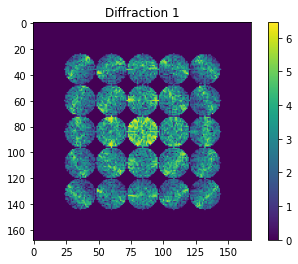

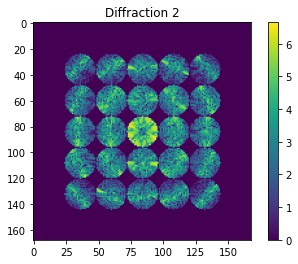

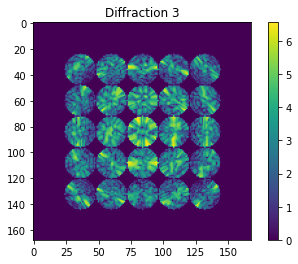

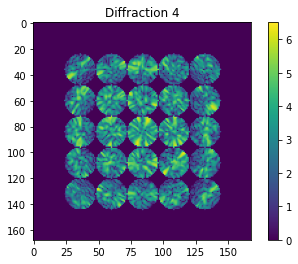

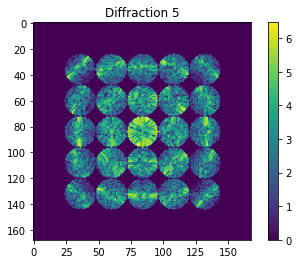

In [7]:
#this will display the random diffraction patterns
def nlogf(x):
    return np.log(1+1000*x)
nlog = np.vectorize(nlogf)
# /(np.array(random_diffs[0])).max()
# (np.array(random_diffs[0])).mean()
    
if Generate_random_diffs:
    
    
    #Mean=(np.array(random_diffs[0])).mean()
    #Std =(np.array(random_diffs[0])).std()
    
    plt.imshow(nlogf(np.array(random_diffs[0]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 1")
    plt.colorbar()
    plt.show()

    plt.imshow(nlogf(np.array(random_diffs[1]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 2")
    plt.colorbar()
    plt.show()

    plt.imshow(nlogf(np.array(random_diffs[2]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 3")
    plt.colorbar()
    plt.show()
    
    plt.imshow(nlogf(np.array(random_diffs[3]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 4")
    plt.colorbar()
    plt.show()
    
    plt.imshow(nlogf(np.array(random_diffs[4]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 5")
    plt.colorbar()
    plt.show()
    
else:
    plt.imshow(nlogf(np.array(diff_pattern[0]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 1")
    plt.colorbar()
    plt.show()

In [8]:
# save the training data or experimental data
name = "normalized_SrTiO3_r12_200_makeunique_150A"
if Generate_random_diffs:
    print("type and shape of UgLists: ", np.array(Ug_normalized_matrix).dtype, np.array(Ug_normalized_matrix).shape)
    np.savetxt(trainingFolder + "/My_labels_" + name + ".csv", np.asarray(Ug_normalized_matrix))
    np.savetxt(trainingFolder + "/My_thickness_" + name + ".csv", np.asarray(random_thickness))
    np.savetxt(trainingFolder + "/random_diffs_" + name + ".csv", np.asarray(random_diffs))
    
    random_diffs_array = []
    for j in range(N_training_data):
        random_diffs_array.append(nlogf(np.array(random_diffs[j]).reshape(detectorNx, detectorNy)))
    random_diffs_array = np.asarray(random_diffs_array)
    print("shape of random pattern: ", random_diffs_array.shape)
    random_diffs_array_reshaped = random_diffs_array.reshape(len(random_diffs_array),-1)
    np.savetxt(trainingFolder + "/My_origin_features_" + name + ".csv", random_diffs_array_reshaped)
    print("type and shape of random pattern array:", np.array(random_diffs_array_reshaped).dtype,np.array(random_diffs_array_reshaped).shape)
    
else:
    np.savetxt(trainingFolder + "/diff_pattern_" + name + ".csv", np.asarray(diff_pattern))
    diff_pattern_array = nlogf(np.array(diff_pattern).reshape(detectorNx, detectorNy))
    print("shape of experimental pattern: ", diff_pattern_array.shape)
    diff_pattern_array_reshaped = diff_pattern_array.reshape(1,-1)
    np.savetxt(trainingFolder + "/My_simulation_pattern_" + name + ".csv", diff_pattern_array_reshaped)
    print("type and shape of experimental pattern array:",np.array(diff_pattern_array_reshaped).dtype,np.array(diff_pattern_array_reshaped).shape)

type and shape of UgLists:  complex128 (200, 81)
shape of random pattern:  (200, 168, 168)
type and shape of random pattern array: float64 (200, 28224)
